## Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle

#### CSVs
* Naming Convention: mm_dd_yyyy_hh_mm_ss

In [2]:
raw_folder= "../csvs/"
clean_folder = '../cleaned_pickles/'
filenames = os.listdir(raw_folder)
print(filenames)

['03_01_2019_02_36_27.txt', '03_02_2019_09_07_22.txt', '03_02_2019_08_28_44.txt', '03_01_2019_02_45_21.txt', '03_02_2019_08_10_00.txt', '03_02_2019_08_41_24.txt', '03_02_2019_08_54_53.txt']


## Import CSV
* -9999 denotes "no value"
* Returns dict with keys() = Latitude, Longitude, Altitude, Speed, XAcceleration, YAcceleration, ZAcceleration, Time

In [3]:
def import_csv(filename):
    data = {}
    with open(filename, newline='\n') as csvfile:
        lines = list(csv.reader(csvfile, delimiter=',', quotechar='|'))
        headers = lines[0]
        values = lines[1:]
        for c in headers:
            data[c] = []
        i = 0
        foundGPS = False
        start_time = 0
        for row in values:
            if not foundGPS and row[0] == '':
                i = i+1
            elif not foundGPS:
                foundGPS = True
                start_time = float(row[7])
            else:
                pass
        values = values[i:] # Throw out points until first GPS datapoint
        for row in values:
            for i in range(len(headers)):
                if row[i] == '':
                    data[headers[i]].append(-9999)
                else:
                    data[headers[i]].append(float(row[i]))
        
        c = len(lines[0])
#         data["Time"] = np.array(data["Time"])-start_time
        data["Time"] = np.array(data["Time"])
    return data

In [4]:
def save_as_csv(dictionary, filename):
    with open(filename, 'w') as f:
        
        headers = list(dictionary.keys())
        
        for header in headers:
            f.write(header+',')
        f.write('\n')
        
        for i in range(len(dictionary[header])):
            for h in headers:
                f.write(str(dictionary[h][i])+',')
            f.write('\n')

In [5]:
data = import_csv(raw_folder+filenames[0])
print(list(data.keys()))

['Latitude', 'Longitude', 'Altitude', 'Speed', 'XAcceleration', 'YAcceleration', 'ZAcceleration', 'Time']


## Cleaning Process
The GPS module updates about once every second, and only when in motion, while the Accelerometer updates about 5 times per second. So, about 4/5 of the rows in the raw CSV file have no GPS coordinates associated with them. To correct for this we need to estimate the GPS information whenever acceleration is updated and GPS is not
* Perfoms Linear interpolation to approximate Lat. Long. inbetween GPS datapoints

In [6]:
class Piecewise:
    def __init__(self, time, values):
        time = np.array(time)
        values = np.array(values)
        x = []
        y = []
        for i in range(time.shape[0]):
            if not values[i] == -9999:
                x.append(time[i])
                y.append(values[i])
        self.x = np.array(x)
        self.y = np.array(y)
    
    # t = number or arraylike
    def __call__(self, t):
        return np.interp(t, self.x, self.y)


    

In [7]:
def populate_missing(data, time = 'none'):
    new = {}
    if time == 'none':
        for c in list(data.keys()):
            new[c] = Piecewise(data["Time"],data[c])(data["Time"])
    else:
        for c in list(data.keys()):
            new[c] = Piecewise(data["Time"],data[c])(time)
    return new

In [8]:
clean = populate_missing(data)

### Mising values have been interpolated

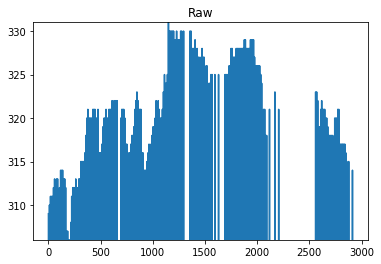

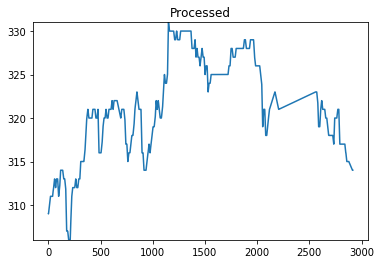

In [9]:
plt.plot(data["Altitude"])
plt.ylim(min(clean["Altitude"]),max(data["Altitude"]))
plt.title("Raw")
plt.show()
plt.plot(clean["Altitude"])
plt.ylim(min(clean["Altitude"]),max(data["Altitude"]))
plt.title("Processed")
plt.show()

### Columns that were already fully populated remain unchanged

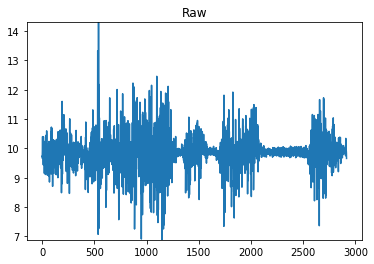

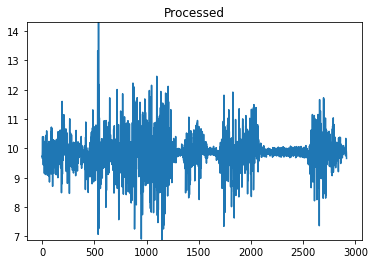

In [10]:
plt.plot(data["XAcceleration"])
plt.ylim(min(clean["XAcceleration"]),max(data["XAcceleration"]))
plt.title("Raw")
plt.show()
plt.plot(clean["XAcceleration"])
plt.ylim(min(clean["XAcceleration"]),max(data["XAcceleration"]))
plt.title("Processed")
plt.show()


## Iterate over all CSVs
* save cleaned data as a pickle containing a python dict{}

In [11]:
# def scrub_all(files):
#     for file in files:
#         raw = import_csv(raw_folder+file)
#         clean = populate_missing(raw)
#         output = open(clean_folder+file[:-4]+".pkl", 'wb')
#         pickle.dump(clean, output)
#         output.close()
    

In [12]:
# scrub_all(filenames)

In [13]:
def heading_angle(lat1,lat2,lon1,lon2):
    delta_lat = lat1-lat2
    delta_lon = lon1-lon2
    X = np.cos(np.deg2rad(lat2))*np.sin(np.deg2rad(lon2-lon1))
    Y = np.cos(np.deg2rad(lat1))*np.sin(np.deg2rad(lat2))- np.sin(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2)) * np.cos(np.deg2rad(lon2-lon1))
    angle = np.arctan2(X,Y)*360/(2*np.pi)
    
    return angle

def heading(latitude, longitude, t):
    lat1 = latitude(t)
    lat2 = latitude(t+1000)
    lon1 = longitude(t)
    lon2 = longitude(t+1000)
    
    return heading_angle(lat1,lat2,lon1,lon2)

In [14]:
print(heading_angle(39.099912,38.627089,-94.581213,-90.200203))

96.51262423499931


In [15]:
infile = open('labels.pkl','rb')
labels = pickle.load(infile)
infile.close()

output = []
for l in labels:
    l = l[:-4].split('__')
    file_name = l[0]
    time = float(l[1])*1000
    csv_name = file_name+'.txt'
    raw = import_csv(raw_folder+csv_name)
    d = populate_missing(raw)
    
    lat_csv = d['Latitude']
    lon_csv = d['Longitude']
    t_csv   = d['Time']
    
    lat_p = Piecewise(t_csv, lat_csv)
    lon_p = Piecewise(t_csv, lon_csv)
    
    lat = lat_p(time)
    lon = lon_p(time)
    
    h = heading(lat_p, lon_p, time)
    
    output.append([lat,lon, h])

    
    
output = np.array(output)

out_dict = {}
out_dict["Latitude"] = output[:,0]
out_dict["Longitude"] = output[:,1]
out_dict["Heading"] = output[:,2]

############ TODO ###############
# Add "Classification to out_dict"


print(output[0])

[ 34.05171571 -83.92720987  40.57998451]


In [16]:
print(out_dict["Heading"][:10])

[ 40.57998451  14.64587014  -9.55323955 -12.91763016 -10.26781236
   0.           2.63524219  33.94362816  34.77638097  32.16764622]


In [17]:
save_as_csv(out_dict,'output.csv')